## DATA PREPARATION

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
from sklearn.cluster import KMeans


real_df = pd.read_table('/projects/genomic-ml/da2343/ml_project_2/robust_algo_trader/data/EURUSD_H1_200702210000_202304242100.tsv')
# real_df = pd.read_table('/Users/newuser/Projects/robust-algo-trader/data/EURUSD_H1_202302010000_202304242100.tsv')

df = real_df.copy()
# take only last 7000 rows
df = df.iloc[-(200+24*7*4):]

# remove the following columns <TICKVOL>, <VOL> and <SPREAD>
df = df.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
df = df.rename(columns={'<DATE>': 'Date', 
                                '<TIME>': 'Time', 
                                '<OPEN>': 'Open', 
                                '<HIGH>': 'High', 
                                '<LOW>': 'Low', 
                                '<CLOSE>': 'Close'
                                })
# combine the date and time columns
df['Date_Time'] = df['Date'] + ' ' + df['Time']
# remove the date and time columns
df = df.drop(['Date', 'Time'], axis=1)
# convert the date_time column to datetime
df['Time'] = pd.to_datetime(df['Date_Time'])
# Rename Date_Time to Time
# df.index = df['Time']
# df.set_index("Time")
# remove the Time column
df = df.drop(['Time'], axis=1)

prices = df["Close"].values
df["SMA"] = talib.SMA(prices, timeperiod=200)
df = df.dropna()

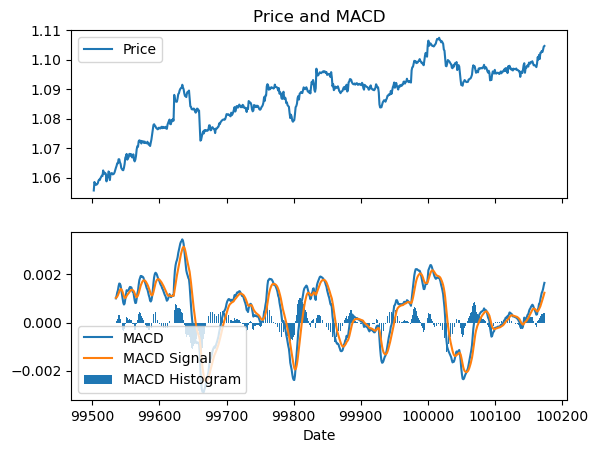

In [3]:
# import libraries
import talib
import matplotlib.pyplot as plt

# assume you have the price data in a pandas dataframe called df
# calculate the macd, macdsignal and macdhist values
macd, macdsignal, macdhist = talib.MACD(df['Close'])

# create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# plot the price data on the first subplot
ax1.plot(df['Close'], label='Price')
ax1.set_title('Price and MACD')
ax1.legend()

# plot the macd, macdsignal and macdhist values on the second subplot
ax2.plot(macd, label='MACD')
ax2.plot(macdsignal, label='MACD Signal')
ax2.bar(df.index, macdhist, label='MACD Histogram')
ax2.set_xlabel('Date')
ax2.legend()

# show the figure
plt.show()


In [4]:
# Define MACD parameters
short_ema = 12
long_ema = 26
signal_ema = 9


# Calculate MACD and signal lines
df["EMA_short"] = df["Close"].ewm(span=short_ema, adjust=False).mean()
df["EMA_long"] = df["Close"].ewm(span=long_ema, adjust=False).mean()

df["MACD"] = df["EMA_short"] - df["EMA_long"]
df["Signal"] = df["MACD"].ewm(span=signal_ema, adjust=False).mean()

# Find MACD crossovers
df["Crossover"] = np.where(df["MACD"] > df["Signal"], 1, -1)
df["Crossover_change"] = df["Crossover"].diff()
df = df.dropna()
df = df.reset_index(drop=True)

In [5]:
df

,Open,High,Low,Close,Date_Time,SMA,EMA_short,EMA_long,MACD,Signal,Crossover,Crossover_change
0,1.05569,1.05901,1.05473,1.05858,2023.03.15 20:00:00,1.063628,1.056135,1.055904,0.000231,0.000046,1,2.0
1,1.05857,1.05925,1.05746,1.05803,2023.03.15 21:00:00,1.063611,1.056426,1.056062,0.000365,0.000110,1,0.0
2,1.05802,1.05834,1.05739,1.05761,2023.03.15 22:00:00,1.063592,1.056608,1.056176,0.000432,0.000174,1,0.0
3,1.05748,1.05783,1.05724,1.05766,2023.03.15 23:00:00,1.063569,1.056770,1.056286,0.000484,0.000236,1,0.0
4,1.05757,1.05812,1.05737,1.05783,2023.03.16 00:00:00,1.063552,1.056933,1.056401,0.000533,0.000296,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
667,1.10237,1.10370,1.10207,1.10294,2023.04.24 17:00:00,1.098075,1.100671,1.099435,0.001237,0.000860,1,0.0
668,1.10294,1.10323,1.10206,1.10260,2023.04.24 18:00:00,1.098125,1.100968,1.099669,0.001299,0.000948,1,0.0
669,1.10260,1.10342,1.10249,1.10340,2023.04.24 19:00:00,1.098180,1.101342,1.099946,0.001397,0.001037,1,0.0
670,1.10341,1.10484,1.10336,1.10441,2023.04.24 20:00:00,1.098238,1.101814,1.100276,0.001538,0.001138,1,0.0


## STRATEGY 1: MACD CROSSOVER + KMeans for TP and SL levels

### KMeans clustering for forecasting TP and SL levels

In [6]:

close_df = df[['Close']]

# reshape the data into a 2D array
X = close_df.values.reshape(-1,1)

# choose the number of clusters (you can use other methods to find the optimal number)
k = 10

# create and fit the k means model
model = KMeans(n_clusters=k, random_state=0, n_init = 100, max_iter = 1000)
model.fit(X)

# get the cluster labels and centroids
labels = model.labels_
centroids = model.cluster_centers_

# # assign the labels and centroids to the dataframe
# df['Label'] = labels
# df['Centroid'] = df['Label'].apply(lambda x: centroids[x])

# # plot the data with the clusters and centroids
# plt.figure(figsize=(10,6))
# plt.plot(df['Close'], label='Price')
# # plt.plot(df['Centroid'], label='Centroid')
# plt.scatter(df.index, df['Centroid'], c=df['Label'], cmap='rainbow', marker='o', s=50, alpha=0.5, label='Cluster')
# plt.title(f'Support and Resistance Levels using K-Means Clustering')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()

In [7]:
df

,Open,High,Low,Close,Date_Time,SMA,EMA_short,EMA_long,MACD,Signal,Crossover,Crossover_change
0,1.05569,1.05901,1.05473,1.05858,2023.03.15 20:00:00,1.063628,1.056135,1.055904,0.000231,0.000046,1,2.0
1,1.05857,1.05925,1.05746,1.05803,2023.03.15 21:00:00,1.063611,1.056426,1.056062,0.000365,0.000110,1,0.0
2,1.05802,1.05834,1.05739,1.05761,2023.03.15 22:00:00,1.063592,1.056608,1.056176,0.000432,0.000174,1,0.0
3,1.05748,1.05783,1.05724,1.05766,2023.03.15 23:00:00,1.063569,1.056770,1.056286,0.000484,0.000236,1,0.0
4,1.05757,1.05812,1.05737,1.05783,2023.03.16 00:00:00,1.063552,1.056933,1.056401,0.000533,0.000296,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
667,1.10237,1.10370,1.10207,1.10294,2023.04.24 17:00:00,1.098075,1.100671,1.099435,0.001237,0.000860,1,0.0
668,1.10294,1.10323,1.10206,1.10260,2023.04.24 18:00:00,1.098125,1.100968,1.099669,0.001299,0.000948,1,0.0
669,1.10260,1.10342,1.10249,1.10340,2023.04.24 19:00:00,1.098180,1.101342,1.099946,0.001397,0.001037,1,0.0
670,1.10341,1.10484,1.10336,1.10441,2023.04.24 20:00:00,1.098238,1.101814,1.100276,0.001538,0.001138,1,0.0


In [8]:


# Define K-means parameters
n_clusters = 5 # Number of clusters for TP and SL levels
random_state = 0 # Random seed for reproducibility

# Initialize an empty numpy array of dictionaries
orders = np.array([])

# Loop through the rows of the dataframe
for i in range(len(df)):
    # If there is a MACD crossover
    if df.loc[i, "Crossover_change"] != 0:
        # Get the ask price
        ask_price = df.loc[i, "Close"]
        # Get the position (buy or sell)
        position = "Buy" if df.loc[i, "Crossover_change"] == 2 else "Sell"
        ## Get the next n rows of price data
        # next_prices = df.loc[i+1:i+n_clusters, "Close"].values.reshape(-1, 1)
        # Fit K-means on the next prices
        # kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto').fit(next_prices)
        # Get the cluster centers as the TP and SL levels
        # tp_sl_levels = kmeans.cluster_centers_.flatten()
        # Sort the levels in ascending order
        # tp_sl_levels.sort()
        
        # make tp_level be about 0.5% above the ask_price
        # make sl_level be about 0.5% below the ask_price
        tp_level = (ask_price * 1.005) if position == "Buy" else (ask_price * 0.995)
        sl_level = (ask_price * 0.995) if position == "Buy" else (ask_price * 1.005)
        
        # tp_level = tp_sl_levels[-1] if position == "Buy" else tp_sl_levels[0]
        # sl_level = tp_sl_levels[0] if position == "Buy" else tp_sl_levels[-1]
        # Calculate the TP and SL ratios
        tp_ratio = abs(tp_level - ask_price) / ask_price
        sl_ratio = abs(sl_level - ask_price) / ask_price
        # Check if the TP ratio is greater than the SL ratio
        # Create a dictionary with the order details
        order = {
                     "ask_price": ask_price,
                     "take_profit_price": tp_level,
                     "stop_loss_price": sl_level,
                     "position": position,
        }
        # Append the dictionary to the numpy array
        orders = np.append(orders, order)

# Print the numpy array of dictionaries
print(orders)


[{'ask_price': 1.05858, 'take_profit_price': 1.0638729, 'stop_loss_price': 1.0532871000000001, 'position': 'Buy'}
 {'ask_price': 1.05878, 'take_profit_price': 1.0534861, 'stop_loss_price': 1.0640739, 'position': 'Sell'}
 {'ask_price': 1.06337, 'take_profit_price': 1.0686868499999997, 'stop_loss_price': 1.0580531499999999, 'position': 'Buy'}
 {'ask_price': 1.06297, 'take_profit_price': 1.05765515, 'stop_loss_price': 1.06828485, 'position': 'Sell'}
 {'ask_price': 1.06729, 'take_profit_price': 1.07262645, 'stop_loss_price': 1.0619535500000001, 'position': 'Buy'}
 {'ask_price': 1.06697, 'take_profit_price': 1.0616351499999999, 'stop_loss_price': 1.0723048499999999, 'position': 'Sell'}
 {'ask_price': 1.0707, 'take_profit_price': 1.0760534999999998, 'stop_loss_price': 1.0653465, 'position': 'Buy'}
 {'ask_price': 1.07225, 'take_profit_price': 1.06688875, 'stop_loss_price': 1.07761125, 'position': 'Sell'}
 {'ask_price': 1.07632, 'take_profit_price': 1.0817016, 'stop_loss_price': 1.0709384, 'po

## Testing the performance of the strategy

In [9]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Load price data
# Initialize an empty list to store the trade outcomes
outcomes = []
test_period = 1000 

update_orders = np.array([])

# Loop through the orders array
for order in orders:
    # Get the order details
    ask_price = order["ask_price"]
    tp_price = order["take_profit_price"]
    sl_price = order["stop_loss_price"]
    position = order["position"]
    # Find the index of the row where the ask price matches the close price in the dataframe
    index = df.index[df["Close"] == ask_price][0]
    # Get the next n rows of price data from the close column of the dataframe, where n is equal to the number of clusters
    next_prices = df.loc[index+1:index+test_period, "Close"].values
    # Initialize a variable to store the trade outcome
    outcome = None
    # Loop through the next prices
    for price in next_prices:
        # If the position is buy, check if the price reaches the TP or SL level
        if position == "Buy":
            # If the price is greater than or equal to the TP level, set the outcome to 1 and break the loop
            if price >= tp_price:
                outcome = 1
                update_orders = np.append(update_orders, order)
                break
            # If the price is less than or equal to the SL level, set the outcome to 0 and break the loop
            elif price <= sl_price:
                outcome = 0
                break
        # If the position is sell, check if the price reaches the TP or SL level
        elif position == "Sell":
            # If the price is less than or equal to the TP level, set the outcome to 1 and break the loop
            if price <= tp_price:
                outcome = 1
                update_orders = np.append(update_orders, order)
                break
            # If the price is greater than or equal to the SL level, set the outcome to 0 and break the loop
            elif price >= sl_price:
                outcome = 0
                break
    # Append the outcome to the outcomes list
    outcomes.append(outcome)

# Convert the outcomes list to a numpy array
# remove None values from outcomes
filtered_outcomes = [x for x in outcomes if x is not None]

pred_y = np.array(filtered_outcomes)

test_y = [1]*len(pred_y)
accuracy = accuracy_score(test_y, pred_y)
print(f"Accuracy: {accuracy}")


Accuracy: 0.4772727272727273


In [10]:
pred_y

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0])

In [11]:
update_orders

array([{'ask_price': 1.05858, 'take_profit_price': 1.0638729, 'stop_loss_price': 1.0532871000000001, 'position': 'Buy'},
       {'ask_price': 1.06337, 'take_profit_price': 1.0686868499999997, 'stop_loss_price': 1.0580531499999999, 'position': 'Buy'},
       {'ask_price': 1.06729, 'take_profit_price': 1.07262645, 'stop_loss_price': 1.0619535500000001, 'position': 'Buy'},
       {'ask_price': 1.0707, 'take_profit_price': 1.0760534999999998, 'stop_loss_price': 1.0653465, 'position': 'Buy'},
       {'ask_price': 1.07632, 'take_profit_price': 1.0817016, 'stop_loss_price': 1.0709384, 'position': 'Buy'},
       {'ask_price': 1.07972, 'take_profit_price': 1.0851186, 'stop_loss_price': 1.0743214, 'position': 'Buy'},
       {'ask_price': 1.07989, 'take_profit_price': 1.0852894499999999, 'stop_loss_price': 1.07449055, 'position': 'Buy'},
       {'ask_price': 1.08858, 'take_profit_price': 1.0831371, 'stop_loss_price': 1.0940229, 'position': 'Sell'},
       {'ask_price': 1.0759, 'take_profit_price'

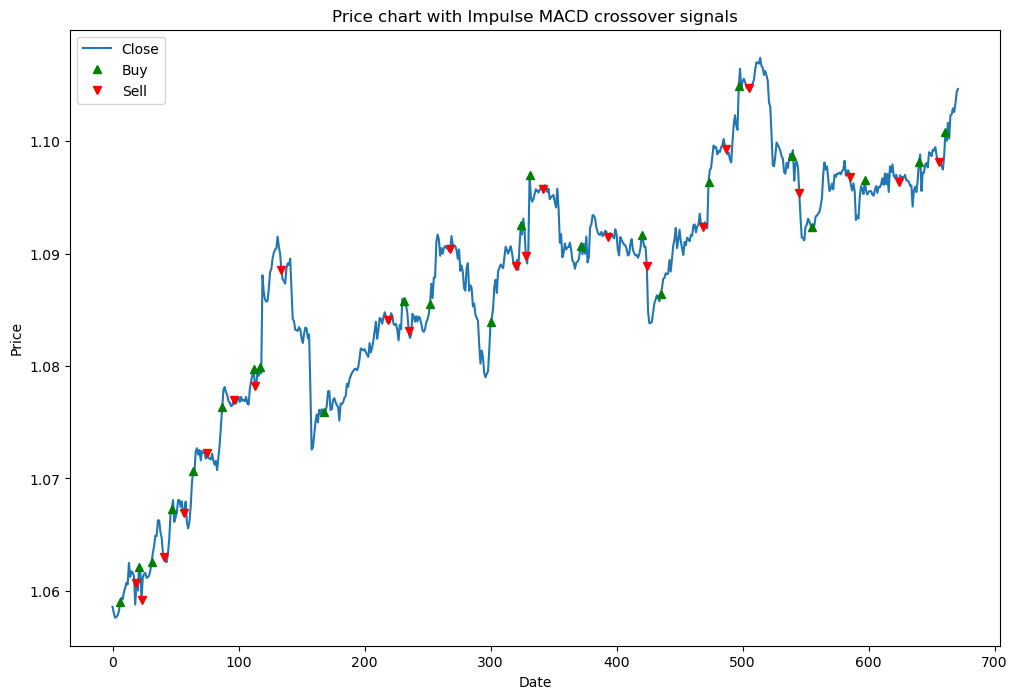

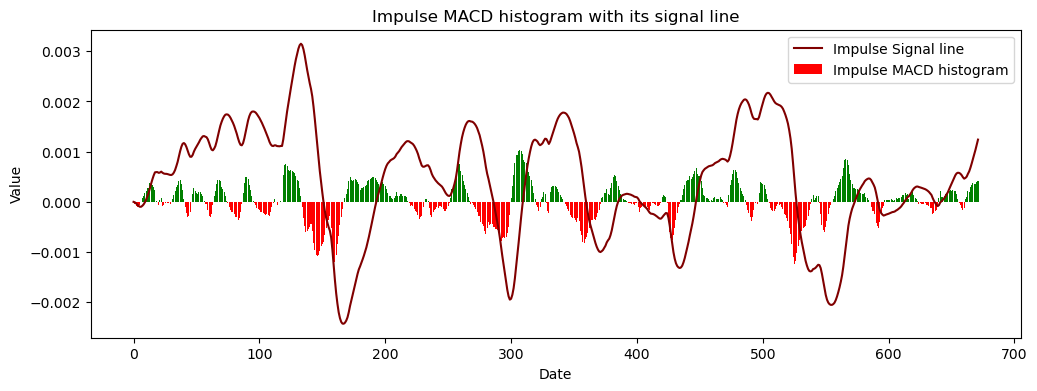

In [13]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load price data

# Calculate MACD and signal lines
df["EMA_short"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA_long"] = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA_short"] - df["EMA_long"]
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

# Calculate high and low moving averages
df["MA_high"] = df["High"].rolling(window=9).mean()
df["MA_low"] = df["Low"].rolling(window=9).mean()

# Calculate Impulse MACD and its signal line
df["Impulse_MACD"] = np.where((df["MACD"] > df["MA_low"]) & (df["MACD"] < df["MA_high"]), 0, df["MACD"])
df["Impulse_Signal"] = df["Impulse_MACD"].ewm(span=9, adjust=False).mean()

# Find Impulse MACD crossovers
df["Crossover"] = np.where(df["Impulse_MACD"] > df["Impulse_Signal"], 1, -1)
df["Crossover_change"] = df["Crossover"].diff()

# Define buy and sell signals
buy_signal = df[df["Crossover_change"] == 2]
sell_signal = df[df["Crossover_change"] == -2]

# Plot the price chart with Impulse MACD and its signal line
plt.figure(figsize=(12,8))
plt.plot(df["Close"], label="Close")
plt.plot(buy_signal["Close"], marker="^", color="green", linestyle="None", label="Buy")
plt.plot(sell_signal["Close"], marker="v", color="red", linestyle="None", label="Sell")
plt.legend()
plt.title("Price chart with Impulse MACD crossover signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# Plot the Impulse MACD histogram with its signal line
plt.figure(figsize=(12,4))
plt.bar(df.index, df["Impulse_MACD"] - df["Impulse_Signal"], color=df["Crossover"].map({1:"green", -1:"red"}), label="Impulse MACD histogram")
plt.plot(df["Impulse_Signal"], color="maroon", label="Impulse Signal line")
plt.legend()
plt.title("Impulse MACD histogram with its signal line")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()
